##데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#데이터 불러오기
f1=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/제주전력시장_현황데이터.csv")
f2=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/제주전력시장_시장전기가격_실시간가격.csv")#실제 가격이 들어있는 데이터
f3=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/기상실측데이터_1.csv")
f4=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/기상실측데이터_2.csv")
f5=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/제주전력시장_시장전기가격_하루전가격.csv")

In [ ]:
import pandas as pd

def adjust_to_nearest_hour(df):
    # 'ts' 열을 숫자형으로 변환 (문자열이나 변환 불가능한 값은 NaN으로 처리)
    df['ts'] = pd.to_numeric(df['ts'], errors='coerce')

    # 한국시간(KST)으로 변환하기 위해 9시간(32400초)을 더함

    # 'ts'에서 %3600으로 나머지를 제거하여 정각에 맞춘 시간 생성
    df['new_ts'] = df['ts'] - (df['ts'] % 3600)
    df['new_ts'] = pd.to_datetime(df['new_ts'], unit='s', errors='coerce')

    # 정각 기준 -15분 ~ +15분 사이에 있는지 확인하고, 범위 밖의 행은 삭제
    def filter_near_hour(row):
        ts_datetime = pd.to_datetime(row['ts'], unit='s', errors='coerce')
        if pd.isna(ts_datetime):  # NaT인지 확인하여 NaT인 경우 반환
            return pd.NaT
        if abs(ts_datetime - row['new_ts']) <= pd.Timedelta(minutes=50):
            return row['new_ts']
        else:
            return pd.NaT

    # 'new_ts' 컬럼에 범위에 맞는 시간만 남기고, 그렇지 않은 경우 NaT로 설정
    df['new_ts'] = df.apply(filter_near_hour, axis=1)

    # NaN 값을 제거하고 나머지 'ts'를 정수형(int)으로 변환
    df = df.dropna(subset=['ts']).copy()
    df["ts"] = (df["ts"] - df["ts"] % 3600).astype(int)

    # NaT 행 삭제 및 인덱스 재정렬
    return df.dropna(subset=['new_ts']).reset_index(drop=True)

# 데이터프레임에 함수 적용
f4 = adjust_to_nearest_hour(f4)
f3 = adjust_to_nearest_hour(f3)


In [ ]:
import pandas as pd

# f6를 f5의 깊은 복사로 생성
#f6 = f5.copy()

# 이후 코드
#f6['하루전가격(원/kWh)_n일'] = f6['하루전가격(원/kWh)']  # n일에 제공되는 데이터
#f6 = f6.drop(columns=['하루전가격(원/kWh)'])
f5['ts'] = f5['ts'] + 86400  # n+1일 데이터

# f1의 ts를 n-1일 제주 전력시장 현황으로 설정
f1['ts'] = f1['ts'] - 86400
f3['ts'] = f3['ts'] - 86400
f4['ts'] = f4['ts'] - 86400
# 데이터프레임 병합
merged_df_f1_f5 = pd.merge(f1, f5, on='ts', how='inner')
merged_df_f1_f5_f4 = pd.merge(merged_df_f1_f5, f4, on='ts', how='inner')
merged_df_f1_f5_f3_f4 = pd.merge(merged_df_f1_f5_f4, f3, on='ts', how='inner')
#merged_df_f1_f5_f3_f4_f6 = pd.merge(merged_df_f1_f5_f3_f4, f6, on='ts', how='inner')
# 데이터셋 분할 및 섞기
temp_merged_1 = merged_df_f1_f5_f3_f4
temp_merged_1 = temp_merged_1.sample(frac=1).reset_index(drop=True)

# X와 y 정의
y = temp_merged_1["하루전가격(원/kWh)"]
X = temp_merged_1.drop(columns=["location_x", "ts", "하루전가격(원/kWh)", "location_y", "new_ts_y", "new_ts_x"])


In [ ]:
X

,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),temp,real_feel_temp,real_feel_temp_shade,...,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h
0,1420000.0,616000.0,228132.00,84153.20,317194.0,805000.0,462000.0,23.5,22.4,21.4,...,23.7,2.0,16.1,86.0,549.0,1013.5,23.3,23.3,15.7,0.0
1,1297000.0,782000.0,0.00,5963.29,20295.3,515000.0,305000.0,27.0,32.5,32.5,...,12.2,0.0,16.1,43.0,9601.0,1008.1,31.1,27.2,25.1,0.0
2,1321000.0,645000.0,0.00,23599.50,39458.5,675000.0,287000.0,27.0,31.3,31.3,...,14.4,0.0,11.3,99.0,2012.0,1006.3,32.2,27.2,25.6,0.1
3,1096000.0,655000.0,17819.00,22903.10,43432.6,442000.0,276000.0,16.2,16.1,14.7,...,7.2,1.0,14.5,82.0,4298.0,1016.9,18.3,16.1,13.5,0.7
4,1374000.0,647000.0,0.00,74587.60,89749.8,727000.0,353000.0,29.2,33.1,33.1,...,11.8,0.0,49.9,0.0,6096.0,1005.0,33.3,29.4,24.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25349,1201000.0,737000.0,0.00,19093.70,34307.3,465000.0,379000.0,15.2,15.7,15.7,...,8.7,0.0,14.5,96.0,518.0,1009.8,18.3,15.0,14.8,0.0
25350,1243000.0,793000.0,1491.78,152606.00,169694.0,450000.0,284000.0,12.3,8.0,7.4,...,31.0,1.0,22.5,6.0,10363.0,1019.0,13.9,12.2,9.0,0.0
25351,1298000.0,658000.0,1538.11,2389.19,16772.2,640000.0,428000.0,25.9,30.9,30.9,...,7.6,0.0,19.3,17.0,10363.0,1006.1,28.9,26.1,24.7,0.0
25352,1360000.0,628000.0,169122.00,52406.60,229210.0,728000.0,394000.0,21.7,21.1,20.1,...,24.6,1.0,16.1,97.0,579.0,1012.9,22.2,21.7,18.6,0.1


##customloss로 학습

In [ ]:
import torch

def customloss(predict, y):#학습용
    # predict를 y와 같은 차원으로 변환
    predict = predict.squeeze()  # (batch_size, 1) -> (batch_size,)

    e1 = torch.zeros_like(y)
    e2 = torch.zeros_like(y)
    accuracy = torch.zeros_like(y)

    positive_mask = y > 0
    negative_mask = y <= 0

    e1_mask = y > 0  # y > 0인 부분 마스크
    e2_mask = y < -1  # y <= 0인 부분 마스크
    e2_adjusted_mask = (y <= 0) & (y >= -1)
    # 각 마스크 조건에 맞는 부분에 대해서만 e1, e2를 계산합니다.
    # e1과 e2에서 분모에 작은 상수를 추가하여 0으로 나누는 것을 방지
    e1[e1_mask] = torch.abs((y[e1_mask] - predict[e1_mask]) / (y[e1_mask]))
    e2[e2_mask] = torch.abs((y[e2_mask] - predict[e2_mask]) / (-y[e2_mask]))
    e2[e2_adjusted_mask] = torch.abs((y[e2_adjusted_mask] - predict[e2_adjusted_mask]) / (-1))

    accuracy[positive_mask] = (predict[positive_mask] > 0).float()
    accuracy[negative_mask] = (predict[negative_mask] <= 0).float()

    e1_mean = e1[e1 != 0].mean() if (e1 != 0).any() else torch.tensor(0.0)
    e2_mean = e2[e2 != 0].mean() if (e2 != 0).any() else torch.tensor(0.0)

    accuracy_mean = accuracy.mean()

    e_F = 0.2 * e1_mean + 0.8 * e2_mean - (accuracy_mean - 0.95)
    if e_F<0:
      e_F=0
    e_F_square = e_F**2
    mse_loss = torch.mean((y - predict)**2)

    return mse_loss+e_F_square*20

In [ ]:
for i in X.columns:
  print(i,X[i][:1])

공급능력(kW) 0    1420000.0
Name: 공급능력(kW), dtype: float64
현재 수요(kW) 0    616000.0
Name: 현재 수요(kW), dtype: float64
태양광 발전량kW) 0    228132.0
Name: 태양광 발전량kW), dtype: float64
풍력 발전량(kW) 0    84153.2
Name: 풍력 발전량(kW), dtype: float64
신재생 발전량 총합(kW) 0    317194.0
Name: 신재생 발전량 총합(kW), dtype: float64
공급 예비력(kW) 0    805000.0
Name: 공급 예비력(kW), dtype: float64
운영 예비력(kW) 0    462000.0
Name: 운영 예비력(kW), dtype: float64
temp 0    23.5
Name: temp, dtype: object
real_feel_temp 0    22.4
Name: real_feel_temp, dtype: object
real_feel_temp_shade 0    21.4
Name: real_feel_temp_shade, dtype: object
rel_hum 0    44.0
Name: rel_hum, dtype: object
dew_point 0    10.7
Name: dew_point, dtype: object
wind_dir 0    225.0
Name: wind_dir, dtype: object
wind_spd 0    21.6
Name: wind_spd, dtype: object
wind_gust_spd 0    23.7
Name: wind_gust_spd, dtype: object
uv_idx 0    2.0
Name: uv_idx, dtype: object
vis 0    16.1
Name: vis, dtype: object
cld_cvr 0    86.0
Name: cld_cvr, dtype: object
ceiling 0    549.0
Name: ceilin

In [ ]:
train_X, val_X, test_X = X[0000:65000], X[65000:],X[1:2]
train_y, val_y, test_y = y[0000:65000], y[65000:],y[1:2]

# Normalize 제거 - X와 y 모두 원래 스케일 사용

# 2. Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
        y = y.apply(pd.to_numeric, errors='coerce').fillna(0)

        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders
batch_size = 2**9
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)
test_dataset = CustomDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. Model definition
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(24, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

# Device setting
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)
print(model)

# MSELoss 정의
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 5. Training function
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = customloss(pred,y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 10 == 0:
            current = batch * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / len(dataloader)
    print(f"Average training loss: {avg_loss:>8f}")

# 6. Validation function
def validate(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss = customloss(pred,y)
            total_loss += loss
    avg_loss = total_loss / num_batches
    print(f"Validation Error: Avg loss: {avg_loss:>8f}")

# 7. Training loop
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, optimizer)
    validate(val_dataloader, model)
print("Done!")

# Run test
print("Testing on unseen data:")


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
epochs = 200

optimizer = optim.Adam(model.parameters(), lr=1e-6)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, optimizer)
    validate(val_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2048.805664  [    0/65000]
loss: 1803.332153  [ 5120/65000]
loss: 1119.900879  [10240/65000]
loss: 1167.632935  [15360/65000]
loss: 1671.929443  [20480/65000]
loss: 1537.891113  [25600/65000]
loss: 1263.229370  [30720/65000]
loss: 1357.006104  [35840/65000]
loss: 1094.328735  [40960/65000]
loss: 1387.731934  [46080/65000]
loss: 1061.084595  [51200/65000]
loss: 1245.505737  [56320/65000]
loss: 1555.939453  [61440/65000]
Average training loss: 1272.940147
Validation Error: Avg loss: 1341.312744
Epoch 2
-------------------------------
loss: 1326.031982  [    0/65000]
loss: 1363.004883  [ 5120/65000]
loss: 1272.784668  [10240/65000]
loss: 1427.353760  [15360/65000]
loss: 1377.824219  [20480/65000]
loss: 1299.391113  [25600/65000]
loss: 1220.046753  [30720/65000]
loss: 1391.700439  [35840/65000]
loss: 1557.816772  [40960/65000]
loss: 985.462402  [46080/65000]
loss: 1039.136597  [51200/65000]
loss: 1368.406860  [56320/65000]
loss: 1463.963501  [6

KeyboardInterrupt: 

In [ ]:
import torch

# 모델 학습이 완료된 후, 학습된 가중치를 저장
torch.save(model, path)

#평가 부분

In [ ]:
y_2=temp_merged_2["실시간 확정 가격(원/kWh)"]
X_2=temp_merged_2.drop(columns=["실시간 확정 가격(원/kWh)","실시간 임시 가격(원/kWh)","ts","location_x"])

NameError: name 'temp_merged_2' is not defined

In [ ]:
import torch

def customloss_actual(predict, y):
    # predict와 y가 batch 단위로 입력된다고 가정하고 수정
    # predict와 y는 각각 (batch_size,) 또는 (batch_size, num_features) 형태의 tensor라고 가정

    # e1과 e2는 배치 내 모든 샘플에 대해 계산되므로 각 배치 크기만큼의 0 텐서를 초기화
    e1 = torch.zeros_like(y)
    e2 = torch.zeros_like(y)
    accuracy = torch.zeros_like(y)  # batch 내 샘플 개수만큼의 accuracy 초기화

    # y > 0인 경우 e1을 계산하고, y <= 0인 경우 e2를 계산합니다.
    # 이를 위해 boolean indexing을 사용하여 조건에 맞는 요소들만 선택합니다.
    e1_mask = y > 0  # y > 0인 부분 마스크
    e2_mask = y < -1  # y <= 0인 부분 마스크
    e2_adjusted_mask = (y <= 0) & (y >= -1)
    # 각 마스크 조건에 맞는 부분에 대해서만 e1, e2를 계산합니다.
    # e1과 e2에서 분모에 작은 상수를 추가하여 0으로 나누는 것을 방지
    e1[e1_mask] = torch.abs((y[e1_mask] - predict[e1_mask]) / (y[e1_mask]))
    e2[e2_mask] = torch.abs((y[e2_mask] - predict[e2_mask]) / (-y[e2_mask]))
    e2[e2_adjusted_mask] = torch.abs((y[e2_adjusted_mask] - predict[e2_adjusted_mask]) / (-1))


    # 정확도 계산: y > 0일 때 predict도 > 0, y <= 0일 때 predict도 <= 0이면 accuracy = 1
    accuracy[e1_mask] = (predict[e1_mask] > 0).float()  # y > 0일 때 predict > 0이면 1
    accuracy[e2_mask] = (predict[e2_mask] <= 0).float()  # y <= 0일 때 predict <= 0이면 1

    # e_F 계산: e1과 e2의 weighted sum - (accuracy - 0.95)
    e_F = 0.2 * e1 + 0.8 * e2 - (accuracy - 0.95)

    # e_F를 제곱하여 loss 값으로 반환합니다.
    # e_F는 각 샘플에 대한 값이므로 최종 loss는 batch 차원에 대해 평균을 취합니다.
    e_F_square = e_F**2

    e1_non_zero_mean = e1[e1 != 0].mean() if (e1 != 0).any() else torch.tensor(0.0)
    e2_non_zero_mean = e2[e2 != 0].mean() if (e2 != 0).any() else torch.tensor(0.0)
    mean_difference = torch.abs((predict - y)).mean()

    print("accuracy는 ",accuracy.mean())
    print(f"e1 (0 제외 평균): {e1_non_zero_mean}")
    print(f"e2 (0 제외 평균): {e2_non_zero_mean}")
    print("e_F의 값은",e_F.mean())
    print("e_f의 길이는:",len(e_F))
    print("predict와 y의 평균 차이는 ",mean_difference)
    return e_F_square.mean()  # batch-wise 평균 loss 반환

모델 예측 검증 부분

In [ ]:
test_X =a_X[-400:]
test_y =a_y[-400:]
batch_size = 64

test_dataset = CustomDataset(test_X, test_y)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
set(a_X)-set(X)

set()

In [ ]:
a_X=a_X.drop(columns=['new_ts_x', 'new_ts_y', '하루전가격(원/kWh)'])

In [ ]:
import pandas as pd

def predict_and_compare(dataloader, model):
    model.eval()  # 모델을 평가 모드로 전환
    predictions = []
    actuals = []

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for X, y in dataloader:
            X = X.to(device)
            pred = model(X)  # 예측 값 반환

            # pred가 단일 값인지 텐서인지 확인하여 처리
            if pred.dim() == 0:  # pred가 단일 값일 경우
                predictions.append(pred.item())  # 단일 값을 리스트에 추가
            else:
                predictions.extend(pred.squeeze().tolist())  # 1차원 텐서일 경우 리스트로 변환하여 추가

            actuals.extend(y.tolist())  # 실제 값 리스트에 추가

    # DataFrame 생성
    df = pd.DataFrame({
        'Actual': actuals,
        'Predicted': predictions
    })

    return df

# 테스트 데이터셋을 통해 예측 및 비교
#result_df_model_only_mse = predict_and_compare(test_dataloader, model1)
result_df_model = predict_and_compare(test_dataloader, model)

In [ ]:
result_df_model

,Actual,Predicted
0,0.000000,124.918816
1,0.000000,124.920334
2,209.550003,151.373093
3,209.550003,151.374741
4,213.080002,123.698067
...,...,...
395,109.580002,153.988373
396,109.580002,154.026566
397,108.459999,127.811043
398,105.599998,129.988266


In [ ]:
temp_merged_1[-50:]["new_ts_y"]

,new_ts_y
5066,2024-11-06 07:00:00
5067,2024-11-06 07:00:00
5068,2024-11-06 08:00:00
5069,2024-11-06 08:00:00
5070,2024-11-06 09:00:00
5071,2024-11-06 09:00:00
5072,2024-11-06 10:00:00
5073,2024-11-06 10:00:00
5074,2024-11-06 11:00:00
5075,2024-11-06 11:00:00


In [ ]:
import torch
import pandas as pd

# 예측 및 실제 값 비교 후 result_df 생성 (위 코드에서 구현된 함수 사용)
#result_df = predict_and_compare(test_dataloader, model)

# DataFrame을 텐서로 변환
y_tensor = torch.tensor(result_df_model['Actual'][-200:].values, dtype=torch.float32)
predict_tensor = torch.tensor(result_df_model['Predicted'][-200:].values, dtype=torch.float32)

# customloss 함수에 텐서 입력
loss = customloss_actual(predict_tensor, y_tensor)
print(f"Custom Loss: {loss.item()}")


accuracy는  tensor(0.9900)
e1 (0 제외 평균): 0.24735553562641144
e2 (0 제외 평균): 101.82962799072266
e_F의 값은 tensor(0.8236)
e_f의 길이는: 200
predict와 y의 평균 차이는  tensor(28.5361)
Custom Loss: 67.92292785644531


In [ ]:
result_df_model

,Actual,Predicted
0,108.199997,133.944000
1,108.199997,134.000885
2,106.760002,126.670952
3,106.760002,126.701385
4,106.849998,121.277489
5,106.849998,121.287727
6,106.629997,114.114510
7,106.629997,114.122429
8,92.239998,114.388550
9,92.239998,114.410271


In [ ]:
temp_merged_1[-500:]

,ts,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),location_x,temp_x,...,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir_y,rain,snow,new_ts_y,하루전가격(원/kWh)
4562,1729972800,1016000.0,528000.0,0.00,41671.1,53786.2,484000.0,254000.0,Songdang-ri,20.2,...,20.94,20.94,89.0,1015.0,4.72,89.0,0.00,0.0,2024-10-26 20:00:00,0.00
4563,1729972800,1016000.0,528000.0,0.00,41671.1,53786.2,484000.0,254000.0,Songdang-ri,20.2,...,19.96,19.96,88.0,1015.0,5.66,70.0,0.13,0.0,2024-10-26 20:00:00,0.00
4564,1729976400,1031000.0,545000.0,0.00,55248.7,69213.0,481000.0,248000.0,Songdang-ri,20.3,...,20.79,20.79,90.0,1015.0,4.62,86.0,0.13,0.0,2024-10-26 21:00:00,0.00
4565,1729976400,1031000.0,545000.0,0.00,55248.7,69213.0,481000.0,248000.0,Songdang-ri,20.3,...,19.96,19.96,88.0,1015.0,5.66,90.0,0.13,0.0,2024-10-26 21:00:00,0.00
4566,1729990800,1070000.0,637000.0,24577.40,72311.7,110778.0,429000.0,198000.0,Songdang-ri,19.0,...,18.96,18.96,94.0,1015.0,5.66,70.0,3.17,0.0,2024-10-27 01:00:00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5057,1730980800,1081000.0,693000.0,5379.81,43584.2,49424.3,389000.0,347000.0,Songdang-ri,14.9,...,14.03,14.03,77.0,1029.0,1.91,34.0,0.00,0.0,2024-11-07 12:00:00,109.58
5058,1730980800,1081000.0,693000.0,5379.81,43584.2,49424.3,389000.0,347000.0,Songdang-ri,14.9,...,13.96,13.96,72.0,1029.0,3.09,140.0,0.00,0.0,2024-11-07 12:00:00,109.58
5059,1730984400,1069000.0,666000.0,2459.60,33321.0,36237.6,403000.0,237000.0,Songdang-ri,14.5,...,14.96,14.96,67.0,1029.0,2.06,130.0,0.00,0.0,2024-11-07 13:00:00,108.46
5060,1730991600,1097000.0,605000.0,0.00,62513.4,62977.1,492000.0,326000.0,Songdang-ri,15.2,...,14.38,14.38,78.0,1029.0,2.41,32.0,0.00,0.0,2024-11-07 15:00:00,105.60


ValueError: x and y must have same first dimension, but have shapes (400,) and (200,)

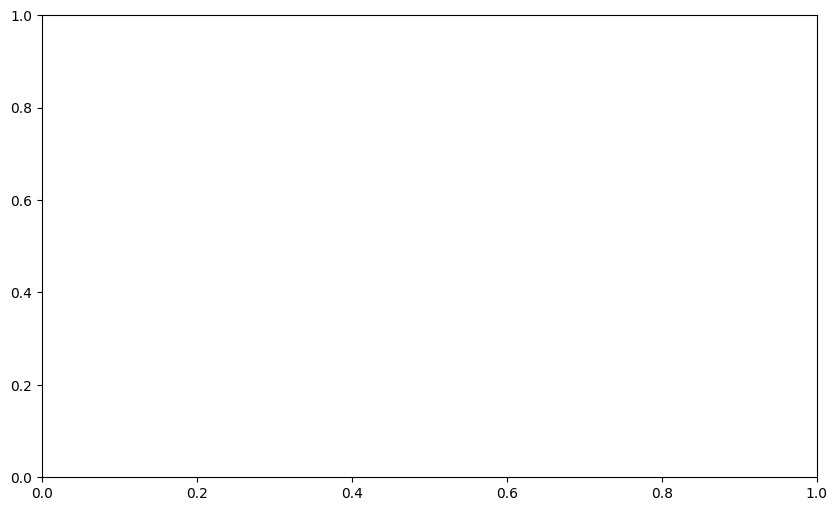

In [ ]:
import matplotlib.pyplot as plt

# Sample data to simulate the user's `result_df` with 'Actual' and 'Predicted' columns
import pandas as pd
import numpy as np

# Creating a sample DataFrame to represent result_df with 'Actual' and 'Predicted' columns


# Plotting the 'Actual' and 'Predicted' values in a line graph
plt.figure(figsize=(10, 6))
plt.plot(result_df_model.index, result_df_model['Actual'], label='Actual', marker='o')
plt.plot(result_df_model.index, result_df_model['Predicted'][-200:], label='Predicted', marker='x')
#plt.plot(result_df_model.index, result_df_model['predicted_only_mse'], label='Predicted_mse')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
a_X=a_X.drop(columns=["하루전가격(원/kWh)"])

##예측 부분

In [ ]:
a1=pd.read_csv("/content/elec_supply.csv")
a5=pd.read_csv("/content/smp_da.csv")
a3=pd.read_csv("/content/actual_weather_1_Songdang-ri.csv")
a4=pd.read_csv("/content/actual_weather_2_Jeju.csv")

In [ ]:
a3 = adjust_to_nearest_hour(a3)
a4 = adjust_to_nearest_hour(a4)

In [ ]:
a3

,location,ts,temp,real_feel_temp,real_feel_temp_shade,rel_hum,dew_point,wind_dir,wind_spd,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h,new_ts
0,Songdang-ri,1709226000,4.6,0.1,0.1,85.0,2.3,293.0,16.9,20.7,0.0,16.1,86.0,579.0,1018.6,6.1,0.6,3.7,0.0,2024-02-29 17:00:00
1,Songdang-ri,1709244000,1.8,-3.6,-3.6,74.0,-2.3,293.0,19.8,25.3,1.0,20.9,21.0,10058.0,1020.7,1.7,-2.8,0.3,0.0,2024-02-29 22:00:00
2,Songdang-ri,1709272800,1.5,-3.7,-5.2,61.0,-5.3,315.0,20.5,55.5,2.0,16.1,69.0,7163.0,1023.4,1.7,-3.3,-0.9,0.0,2024-03-01 06:00:00
3,Songdang-ri,1709287200,-0.6,-5.4,-5.4,74.0,-4.7,315.0,13.7,27.6,0.0,22.5,82.0,10363.0,1025.1,-0.6,-5.0,-1.9,0.0,2024-03-01 10:00:00
4,Songdang-ri,1709305200,-0.3,-5.6,-5.6,64.0,-6.3,315.0,15.1,26.1,0.0,16.1,87.0,610.0,1023.7,-0.6,-5.0,-2.3,0.0,2024-03-01 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698,Songdang-ri,1730973600,14.7,14.6,14.6,70.0,9.4,270.0,6.5,9.9,0.0,22.5,33.0,10150.0,1028.8,16.1,14.4,11.9,0.0,2024-11-07 10:00:00
2699,Songdang-ri,1730977200,14.8,14.5,14.5,68.0,9.0,270.0,7.2,12.6,0.0,16.1,37.0,10180.0,1028.4,16.1,15.0,11.7,0.0,2024-11-07 11:00:00
2700,Songdang-ri,1730980800,14.9,14.5,14.5,67.0,8.9,270.0,7.6,11.2,0.0,16.1,37.0,10150.0,1028.4,17.8,15.0,11.7,0.0,2024-11-07 12:00:00
2701,Songdang-ri,1730984400,14.5,13.7,13.7,70.0,9.0,270.0,9.0,10.6,0.0,22.5,41.0,1707.0,1028.1,16.1,14.4,11.7,0.0,2024-11-07 13:00:00


In [ ]:
import pandas as pd

# a6를 a5의 깊은 복사로 생성
#a6 = a5.copy()

# 이후 코드
#a6['하루전가격(원/kWh)_n일'] = a6['하루전가격(원/kWh)']  # n일에 제공되는 데이터
#a6 = a6.drop(columns=['하루전가격(원/kWh)'])
a5['ts'] = a5['ts'] - a5['ts']%3600  # n+1일 데이터
a5['ts'] = a5['ts'] + 86400 * 2
# a1의 ts를 n-1일 제주 전력시장 현황으로 설정
a1['ts'] = a1['ts']
a3['ts'] = a3['ts']
a4['ts'] = a4['ts']
# 데이터프레임 병합
merged_df_a1_a3 = pd.merge(a1, a3, on='ts', how='inner')
merged_df_a1_a3_a4 = pd.merge(merged_df_a1_a3, a4, on='ts', how='inner')
merged_df_a1_a3_a4_a5 = pd.merge(merged_df_a1_a3_a4, a5, on='ts', how='inner')
#merged_df_a1_a5_a3_a4_a6 = pd.merge(merged_df_a1_a5_a3_a4, a6, on='ts', how='inner')

# 데이터셋 분할 및 섞기
temp_merged_1 = merged_df_a1_a3_a4_a5


# X와 y 정의
a_y = temp_merged_1["하루전가격(원/kWh)"]
a_X = temp_merged_1.drop(columns=["location_x", "ts", "location_y"])


In [ ]:
a_X=a_X.drop(columns=["new_ts_x","new_ts_y"])

In [ ]:
a_X[-500:]

,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),temp_x,real_feel_temp,real_feel_temp_shade,...,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir_y,rain,snow,new_ts_y,하루전가격(원/kWh)
4562,1016000.0,528000.0,0.00,41671.1,53786.2,484000.0,254000.0,20.2,18.5,18.5,...,20.94,20.94,89.0,1015.0,4.72,89.0,0.00,0.0,2024-10-26 20:00:00,0.00
4563,1016000.0,528000.0,0.00,41671.1,53786.2,484000.0,254000.0,20.2,18.5,18.5,...,19.96,19.96,88.0,1015.0,5.66,70.0,0.13,0.0,2024-10-26 20:00:00,0.00
4564,1031000.0,545000.0,0.00,55248.7,69213.0,481000.0,248000.0,20.3,21.7,21.7,...,20.79,20.79,90.0,1015.0,4.62,86.0,0.13,0.0,2024-10-26 21:00:00,0.00
4565,1031000.0,545000.0,0.00,55248.7,69213.0,481000.0,248000.0,20.3,21.7,21.7,...,19.96,19.96,88.0,1015.0,5.66,90.0,0.13,0.0,2024-10-26 21:00:00,0.00
4566,1070000.0,637000.0,24577.40,72311.7,110778.0,429000.0,198000.0,19.0,18.1,18.1,...,18.96,18.96,94.0,1015.0,5.66,70.0,3.17,0.0,2024-10-27 01:00:00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5057,1081000.0,693000.0,5379.81,43584.2,49424.3,389000.0,347000.0,14.9,14.5,14.5,...,14.03,14.03,77.0,1029.0,1.91,34.0,0.00,0.0,2024-11-07 12:00:00,109.58
5058,1081000.0,693000.0,5379.81,43584.2,49424.3,389000.0,347000.0,14.9,14.5,14.5,...,13.96,13.96,72.0,1029.0,3.09,140.0,0.00,0.0,2024-11-07 12:00:00,109.58
5059,1069000.0,666000.0,2459.60,33321.0,36237.6,403000.0,237000.0,14.5,13.7,13.7,...,14.96,14.96,67.0,1029.0,2.06,130.0,0.00,0.0,2024-11-07 13:00:00,108.46
5060,1097000.0,605000.0,0.00,62513.4,62977.1,492000.0,326000.0,15.2,13.9,13.9,...,14.38,14.38,78.0,1029.0,2.41,32.0,0.00,0.0,2024-11-07 15:00:00,105.60


In [ ]:
from datetime import datetime, timezone, timedelta

def timestamp_to_kst(unix_timestamp):
    # Unix 타임스탬프를 UTC로 변환
    utc_time = datetime.fromtimestamp(unix_timestamp, timezone.utc)
    # UTC에 9시간을 더해 한국 시간으로 변환
    kst_time = utc_time + timedelta(hours=9)
    return kst_time.strftime('%Y3-%m-%d %H:%M:%S')

# 예제
unix_timestamp = 		1730815200
print(timestamp_to_kst(unix_timestamp))  # 출력: 2024-11-25 20:00:00


20243-11-05 23:00:00


In [ ]:
a3

,location,ts,temp,real_feel_temp,real_feel_temp_shade,rel_hum,dew_point,wind_dir,wind_spd,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h,new_ts
0,Sangmo-ri,1709226000,8.3,0.6,0.6,76.0,4.4,338.0,43.6,43.6,0.0,16.1,88.0,579.0,1018.3,10.0,3.3,6.5,0.0,2024-02-29 17:00:00
1,Sangmo-ri,1709244000,5.8,-2.6,-2.6,75.0,1.8,248.0,43.6,43.6,1.0,22.5,52.0,6096.0,1021.0,7.2,0.0,4.1,0.0,2024-02-29 22:00:00
2,Sangmo-ri,1709265600,5.0,-4.3,-5.4,73.0,0.6,338.0,63.8,63.8,3.0,22.5,83.0,5974.0,1025.0,6.7,-2.2,3.2,0.0,2024-03-01 04:00:00
3,Sangmo-ri,1709269200,5.1,-4.0,-5.0,69.0,-0.1,315.0,58.7,77.9,2.0,16.1,84.0,7163.0,1025.0,6.7,-1.7,2.9,0.0,2024-03-01 05:00:00
4,Sangmo-ri,1709287200,4.0,-5.8,-5.8,73.0,-0.5,338.0,41.4,45.2,0.0,22.5,89.0,7894.0,1025.1,3.9,-2.2,2.3,0.1,2024-03-01 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707,Sangmo-ri,1730800800,14.5,9.3,9.3,75.0,10.1,338.0,45.0,51.7,0.0,22.5,26.0,10363.0,1022.0,16.1,14.4,12.1,0.0,2024-11-05 10:00:00
3708,Sangmo-ri,1730804400,14.4,9.2,9.2,72.0,9.5,338.0,44.7,67.3,0.0,16.1,32.0,10363.0,1021.7,16.1,14.4,11.9,0.0,2024-11-05 11:00:00
3709,Sangmo-ri,1730808000,15.4,10.6,10.6,68.0,9.6,338.0,45.4,67.3,0.0,16.1,20.0,10058.0,1021.7,18.3,15.6,12.3,0.0,2024-11-05 12:00:00
3710,Sangmo-ri,1730811600,13.8,8.5,8.5,79.0,10.3,338.0,42.5,53.3,0.0,22.5,14.0,10211.0,1021.3,17.2,13.9,12.0,0.0,2024-11-05 13:00:00


In [ ]:
temp_merged_1

,ts,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),location_x,temp_x,...,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir_y,rain,snow,new_ts_y,하루전가격(원/kWh)
0,1709226000,1403000.0,736000.0,0.00,245230.0,261327.0,666000.0,342000.0,Sangmo-ri,8.3,...,6.15,6.15,71.0,1024.0,9.52,342.0,0.77,0.0,2024-02-29 17:00:00,95.30
1,1709226000,1403000.0,736000.0,0.00,245230.0,261327.0,666000.0,342000.0,Sangmo-ri,8.3,...,6.96,6.96,61.0,1023.0,5.14,340.0,0.00,0.0,2024-02-29 17:00:00,95.30
2,1709244000,1396000.0,818000.0,0.00,243533.0,259615.0,578000.0,358000.0,Sangmo-ri,5.8,...,3.47,3.47,69.0,1025.0,9.58,344.0,0.00,0.0,2024-02-29 22:00:00,111.40
3,1709244000,1396000.0,818000.0,0.00,243533.0,259615.0,578000.0,358000.0,Sangmo-ri,5.8,...,3.96,3.96,65.0,1025.0,5.66,340.0,0.00,0.0,2024-02-29 22:00:00,111.40
4,1709265600,1538000.0,726000.0,158618.00,221596.0,395670.0,811000.0,435000.0,Sangmo-ri,5.0,...,3.53,3.53,62.0,1027.0,10.90,332.0,0.00,0.0,2024-03-01 04:00:00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7033,1730808000,1232000.0,672000.0,4731.27,292517.0,297494.0,561000.0,389000.0,Sangmo-ri,15.4,...,13.52,13.52,63.0,1024.0,8.20,336.0,0.00,0.0,2024-11-05 12:00:00,127.62
7034,1730808000,1232000.0,672000.0,4731.27,292517.0,297494.0,561000.0,389000.0,Sangmo-ri,15.4,...,13.96,13.96,51.0,1024.0,6.69,320.0,0.00,0.0,2024-11-05 12:00:00,127.62
7035,1730811600,1243000.0,646000.0,1668.77,304054.0,305965.0,596000.0,409000.0,Sangmo-ri,13.8,...,13.76,13.76,62.0,1024.0,8.62,339.0,0.00,0.0,2024-11-05 13:00:00,107.46
7036,1730811600,1243000.0,646000.0,1668.77,304054.0,305965.0,596000.0,409000.0,Sangmo-ri,13.8,...,13.96,13.96,54.0,1024.0,5.66,320.0,0.00,0.0,2024-11-05 13:00:00,107.46


In [ ]:
a_X

,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),cloud,temp_x,temp_max,...,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h
0,1507000.0,717000.0,148727.0,202607.0,365198.0,790000.0,441000.0,96.0,6.15,6.15,...,43.6,0.0,16.1,88.0,579.0,1018.3,10.0,3.3,6.5,0.0
1,1507000.0,717000.0,148727.0,202607.0,365198.0,790000.0,441000.0,75.0,6.96,6.96,...,43.6,0.0,16.1,88.0,579.0,1018.3,10.0,3.3,6.5,0.0
2,1481000.0,786000.0,89724.3,234083.0,338934.0,695000.0,473000.0,82.0,3.47,3.47,...,43.6,1.0,22.5,52.0,6096.0,1021.0,7.2,0.0,4.1,0.0
3,1481000.0,786000.0,89724.3,234083.0,338934.0,695000.0,473000.0,75.0,3.96,3.96,...,43.6,1.0,22.5,52.0,6096.0,1021.0,7.2,0.0,4.1,0.0
4,1380000.0,945000.0,0.0,223455.0,238656.0,435000.0,333000.0,100.0,3.53,3.53,...,63.8,3.0,22.5,83.0,5974.0,1025.0,6.7,-2.2,3.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7005,1255000.0,590000.0,227397.0,98875.7,326514.0,691000.0,482000.0,40.0,14.96,14.96,...,36.8,0.0,16.1,8.0,3200.0,1020.3,18.9,15.6,13.8,0.0
7006,1263000.0,530000.0,234390.0,98437.5,333068.0,775000.0,543000.0,100.0,14.56,14.56,...,36.4,0.0,22.5,44.0,4663.0,1020.7,18.9,15.6,13.4,0.0
7007,1263000.0,530000.0,234390.0,98437.5,333068.0,775000.0,543000.0,75.0,14.96,14.96,...,36.4,0.0,22.5,44.0,4663.0,1020.7,18.9,15.6,13.4,0.0
7008,1334000.0,676000.0,224941.0,177670.0,402735.0,730000.0,475000.0,100.0,14.35,14.35,...,57.4,0.0,16.1,47.0,4877.0,1021.0,18.9,15.6,13.3,0.1


In [ ]:
set(a_X)-set(X)

set()

In [ ]:
a_X=a_X[70000:]
a_y=a_y[70000:]

In [ ]:
set(a_X)-set(X)

set()

In [ ]:
a2['ts_datetime'] = pd.to_datetime(a2['ts'], unit='s', utc=True)

# Step 2: Find the latest timestamp
max_ts = a2['ts_datetime'].max()

# Step 3: Round up to the next full hour
# If the timestamp is already at the exact hour, it stays the same
rounded_up_ts = max_ts.ceil('H')

# Step 4: Convert the rounded datetime back to epoch time
rounded_up_epoch = int(rounded_up_ts.timestamp())

# Step 5: Filter the DataFrame to keep only rows with 'ts' >= rounded_up_epoch
filtered_a2 = a2[a2['ts'] >= rounded_up_epoch].copy()

# (Optional) Drop the auxiliary 'ts_datetime' column if not needed
filtered_a2.drop(columns=['ts_datetime'], inplace=True)

# Display the filtered DataFrame
print(filtered_a2)

Empty DataFrame
Columns: [location, ts, cloud, temp, temp_max, temp_min, humidity, ground_press, wind_speed, wind_dir, rain, snow, datetime_kst, rounded_hour]
Index: []


<ipython-input-47-490a58e94f32>:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rounded_up_ts = max_ts.ceil('H')


In [ ]:
a_X

,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),하루전가격(원/kWh),ts1_x,temp_x,...,temp_y,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir_y,rain,snow,ts1_y
0,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,107.39,2024-03-01 00:00:00,1.1,...,-1.77,-1.77,-1.77,61.0,1027.0,7.46,332.0,0.00,0.0,2024-03-02 00:00:00
1,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,107.39,2024-03-01 00:00:00,1.1,...,3.23,3.23,3.23,59.0,1027.0,9.99,337.0,0.00,0.0,2024-03-02 00:00:00
2,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,107.39,2024-03-01 00:00:00,1.1,...,2.32,2.32,2.32,61.0,1027.0,8.70,329.0,0.00,0.0,2024-03-02 00:00:00
3,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,107.39,2024-03-01 00:00:00,1.1,...,-1.77,-1.77,-1.77,61.0,1027.0,7.46,332.0,0.00,0.0,2024-03-02 00:00:00
4,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,107.39,2024-03-01 00:00:00,1.1,...,3.23,3.23,3.23,59.0,1027.0,9.99,337.0,0.00,0.0,2024-03-02 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377362,1295000.0,591000.0,0.0,226052.0,226173.0,699000.0,416000.0,105.14,2024-10-31 23:00:00,19.2,...,20.49,20.49,20.49,95.0,1009.0,14.57,58.0,9.95,0.0,2024-11-01 23:00:00
2377363,1295000.0,591000.0,0.0,226052.0,226173.0,699000.0,416000.0,105.14,2024-10-31 23:00:00,19.2,...,18.96,18.96,18.96,100.0,1010.0,7.20,90.0,13.19,0.0,2024-11-01 23:00:00
2377364,1295000.0,591000.0,0.0,226052.0,226173.0,699000.0,416000.0,105.14,2024-10-31 23:00:00,18.1,...,16.55,16.55,16.55,96.0,1009.0,12.55,55.0,12.15,0.0,2024-11-01 23:00:00
2377365,1295000.0,591000.0,0.0,226052.0,226173.0,699000.0,416000.0,105.14,2024-10-31 23:00:00,18.1,...,20.49,20.49,20.49,95.0,1009.0,14.57,58.0,9.95,0.0,2024-11-01 23:00:00


In [ ]:
filtered_a2

,location,ts,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow,datetime_kst,rounded_hour


In [ ]:
# ts 열을 DatetimeIndex로 변환 (이미 UTC의 한국시간이므로 추가 변환 필요 없음)
a1['ts'] = pd.to_datetime(a1['ts'], unit='s')
a2['ts'] = pd.to_datetime(a2['ts'], unit='s')
a3['ts'] = pd.to_datetime(a3['ts'], unit='s')
a4['ts'] = pd.to_datetime(a4['ts'], unit='s')

# 각 데이터프레임에서 ts를 시간 단위로 그룹화하여 시간당 첫 번째 데이터만 선택
a1 = a1.groupby(pd.Grouper(key='ts', freq='h')).first().dropna().reset_index()
a2 = a2.groupby(pd.Grouper(key='ts', freq='h')).first().dropna().reset_index()
a3 = a3.groupby(pd.Grouper(key='ts', freq='h')).first().dropna().reset_index()
a4 = a4.groupby(pd.Grouper(key='ts', freq='h')).first().dropna().reset_index()

# 데이터프레임 병합
merged_df_a1_a2 = pd.merge(a1, a2, on='ts', how='inner')
merged_df_a1_a2_a4 = pd.merge(merged_df_a1_a2, a4, on='ts', how='inner')
merged_df_a1_a2_a3_a4 = pd.merge(merged_df_a1_a2_a4, a3, on='ts', how='inner')

temp_merged_1 = merged_df_a1_a2_a3_a4

# X와 y 설정
a_y = temp_merged_1["하루전가격(원/kWh)"]
a_X = temp_merged_1.drop(columns=["location_x","location_y"])

# 결과 확인


<ipython-input-69-0f2ad56301de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1['ts'] = pd.to_datetime(a1['ts'], unit='s')


In [ ]:
from datetime import datetime, timezone, timedelta

def timestamp_to_kst(unix_timestamp):
    # Unix 타임스탬프를 UTC로 변환
    utc_time = datetime.fromtimestamp(unix_timestamp, timezone.utc)
    # UTC에 9시간을 더해 한국 시간으로 변환
    kst_time = utc_time + timedelta(hours=9)
    return kst_time.strftime('%Y-%m-%d %H:%M:%S')

# 예제
unix_timestamp = 		1730728800
print(timestamp_to_kst(unix_timestamp))  # 출력: 2024-11-25 20:00:00


2024-11-04 23:00:00


In [ ]:
a_X

NameError: name 'a_X' is not defined

In [ ]:
a1

NameError: name 'a1' is not defined

In [ ]:
4757249-800

4756449

In [ ]:
a4

,ts,하루전가격(원/kWh)
0,1709218800,107.39
1,1709222400,107.39
2,1709226000,95.30
3,1709229600,87.89
4,1709233200,0.00
...,...,...
5876,1730372400,135.30
5877,1730376000,130.87
5878,1730379600,132.91
5879,1730383200,105.14


In [ ]:
4756986-4757248

-262

In [ ]:
import pandas as pd

# 모든 행과 열을 출력하도록 설정
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns',40)




In [ ]:
import pandas as pd
from datetime import timedelta

# ts 열을 UTC에서 한국 시간(KST)으로 변환
temp_merged_1['datetime_kst'] = pd.to_datetime(temp_merged_1['ts'], unit='s') + timedelta(hours=9)

# 결과 확인
temp_merged_1[5800:]

,ts,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),location_x,cloud,temp_x,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir_x,rain,snow,하루전가격(원/kWh),location_y,temp_y,real_feel_temp,real_feel_temp_shade,rel_hum,dew_point,wind_dir_y,wind_spd,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h,datetime_kst
5800,2024-10-30 03:00:00,1373000.0,561000.0,272770.00,62272.6,350140.0,833000.0,641000.0,Cheju-do,100.0,15.93,15.93,15.93,64.0,1021.0,3.96,33.0,0.0,0.0,109.93,Bonggae-dong,21.1,21.3,19.1,64.0,13.9,68.0,20.4,20.4,3.0,16.1,70.0,9144.0,1022.0,21.1,21.1,16.8,0.0,2024-10-30 12:00:00
5801,2024-10-30 04:00:00,1384000.0,617000.0,254864.00,95426.1,363159.0,727000.0,595000.0,Cheju-do,100.0,16.10,16.10,16.10,62.0,1020.0,3.44,46.0,0.0,0.0,100.40,Bonggae-dong,21.1,20.8,19.1,59.0,12.8,68.0,20.4,20.4,3.0,16.1,70.0,6096.0,1021.0,21.1,21.1,16.0,0.0,2024-10-30 13:00:00
5802,2024-10-30 05:00:00,1334000.0,600000.0,231310.00,69020.4,313249.0,729000.0,561000.0,Cheju-do,100.0,16.35,16.35,16.35,59.0,1020.0,3.91,46.0,0.0,0.0,100.58,Bonggae-dong,21.1,21.4,19.3,59.0,12.8,45.0,16.7,16.7,3.0,16.1,40.0,10363.0,1021.0,21.1,21.1,16.0,0.0,2024-10-30 14:00:00
5803,2024-10-30 06:00:00,1252000.0,651000.0,150932.00,66827.5,231578.0,596000.0,443000.0,Cheju-do,100.0,16.13,16.13,16.13,60.0,1020.0,4.46,61.0,0.0,0.0,110.68,Bonggae-dong,21.1,20.5,19.3,59.0,12.8,68.0,16.7,16.7,2.0,16.1,50.0,6096.0,1020.0,21.1,21.1,16.0,0.0,2024-10-30 15:00:00
5804,2024-10-30 07:00:00,1237000.0,674000.0,87016.80,62674.7,162021.0,558000.0,352000.0,Cheju-do,100.0,15.93,15.93,15.93,64.0,1020.0,4.54,59.0,0.0,0.0,109.06,Bonggae-dong,20.0,19.1,18.2,63.0,12.8,68.0,16.7,16.7,1.0,16.1,0.0,12192.0,1020.0,19.4,20.0,15.8,0.0,2024-10-30 16:00:00
5805,2024-10-30 08:00:00,1231000.0,706000.0,37130.40,69136.4,118523.0,521000.0,304000.0,Cheju-do,100.0,15.42,15.42,15.42,67.0,1020.0,4.93,57.0,0.0,0.0,116.86,Bonggae-dong,20.0,18.4,18.4,63.0,12.8,68.0,16.7,16.7,0.0,16.1,0.0,12192.0,1020.0,19.4,20.0,15.8,0.0,2024-10-30 17:00:00
5806,2024-10-30 09:00:00,1226000.0,737000.0,3756.74,48652.8,65673.4,483000.0,411000.0,Cheju-do,100.0,14.81,14.81,14.81,69.0,1021.0,5.00,64.0,0.0,0.0,117.02,Bonggae-dong,18.9,17.3,17.3,67.0,12.8,90.0,13.0,13.0,0.0,16.1,0.0,12192.0,1021.0,19.4,18.9,15.4,0.0,2024-10-30 18:00:00
5807,2024-10-30 10:00:00,1273000.0,738000.0,5176.72,78646.7,98417.6,531000.0,463000.0,Cheju-do,100.0,14.71,14.71,14.71,70.0,1021.0,5.51,63.0,0.0,0.0,117.12,Bonggae-dong,17.8,16.8,16.8,72.0,12.8,113.0,11.1,11.1,0.0,16.1,0.0,12192.0,1021.0,18.3,17.8,14.9,0.0,2024-10-30 19:00:00
5808,2024-10-30 11:00:00,1310000.0,722000.0,7088.84,94024.4,115942.0,584000.0,392000.0,Cheju-do,100.0,14.95,14.95,14.95,67.0,1021.0,5.65,65.0,0.0,0.0,116.32,Bonggae-dong,17.8,16.2,16.2,72.0,12.8,113.0,14.8,14.8,0.0,16.1,0.0,12192.0,1021.0,18.3,17.8,14.9,0.0,2024-10-30 20:00:00
5809,2024-10-30 12:00:00,1310000.0,686000.0,5770.46,87378.5,107104.0,619000.0,346000.0,Cheju-do,100.0,15.09,15.09,15.09,66.0,1022.0,6.35,61.0,0.0,0.0,117.33,Bonggae-dong,17.8,16.2,16.2,63.0,11.1,113.0,14.8,14.8,0.0,16.1,10.0,6096.0,1022.0,18.3,17.8,14.1,0.0,2024-10-30 21:00:00


In [ ]:
a_y

,실시간 임시 가격(원/kWh)
0,112.19
1,112.19
2,112.19
3,112.19
4,112.19
...,...
173335,116.51
173336,116.51
173337,116.51
173338,116.51


In [ ]:
temp_merged_1

,ts,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),실시간 임시 가격(원/kWh),실시간 확정 가격(원/kWh),...,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h
0,1709218800,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,37.7,0.0,17.7,98.0,579.0,1022.0,8.3,3.3,4.5,0.0
1,1709218800,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,31.8,0.0,17.7,97.0,579.0,1022.0,6.1,0.6,2.5,0.0
2,1709218800,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,43.2,0.0,17.7,100.0,762.0,1022.0,8.9,2.8,5.1,0.0
3,1709218800,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,18.0,0.0,16.1,99.0,579.0,1022.0,7.8,2.8,4.8,0.1
4,1709218800,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,17.6,0.0,20.9,91.0,579.0,1015.9,10.0,7.2,7.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381301,1729522800,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,20.5,0.0,22.5,100.0,762.0,1017.0,23.3,22.8,21.4,0.0
381302,1729522800,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,24.1,0.0,6.4,80.0,610.0,1020.1,22.8,22.2,20.1,0.2
381303,1729522800,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,22.2,0.0,16.1,100.0,610.0,1017.0,23.3,22.2,21.5,0.0
381304,1729522800,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,22.2,0.0,16.1,100.0,1219.0,1017.0,23.3,22.2,21.5,0.0


In [ ]:
a1

,ts,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW)
0,1704034800,1298000.0,769000.0,0.0,125426.0,133103.0,529000.0,323000.0
1,1704035100,1299000.0,761000.0,0.0,130393.0,137867.0,538000.0,339000.0
2,1704035400,1290000.0,755000.0,0.0,120691.0,128133.0,534000.0,335000.0
3,1704035700,1277000.0,756000.0,0.0,107771.0,115519.0,521000.0,325000.0
4,1704036000,1269000.0,753000.0,0.0,99264.4,107153.0,515000.0,318000.0
...,...,...,...,...,...,...,...,...
84075,1729607700,1254000.0,624000.0,0.0,247628.0,256210.0,625000.0,277000.0
84076,1729608000,1248000.0,618000.0,0.0,246598.0,255217.0,627000.0,277000.0
84077,1729608300,1255000.0,621000.0,0.0,251494.0,260161.0,630000.0,281000.0
84078,1729608600,1259000.0,612000.0,0.0,252912.0,261535.0,642000.0,290000.0


In [ ]:
temp_merged_1

,ts,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),실시간 임시 가격(원/kWh),실시간 확정 가격(원/kWh),...,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h
0,1709218800,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,37.7,0.0,17.7,98.0,579.0,1022.0,8.3,3.3,4.5,0.0
1,1709218800,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,31.8,0.0,17.7,97.0,579.0,1022.0,6.1,0.6,2.5,0.0
2,1709218800,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,43.2,0.0,17.7,100.0,762.0,1022.0,8.9,2.8,5.1,0.0
3,1709218800,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,18.0,0.0,16.1,99.0,579.0,1022.0,7.8,2.8,4.8,0.1
4,1709218800,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,17.6,0.0,20.9,91.0,579.0,1015.9,10.0,7.2,7.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381301,1729522800,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,20.5,0.0,22.5,100.0,762.0,1017.0,23.3,22.8,21.4,0.0
381302,1729522800,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,24.1,0.0,6.4,80.0,610.0,1020.1,22.8,22.2,20.1,0.2
381303,1729522800,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,22.2,0.0,16.1,100.0,610.0,1017.0,23.3,22.2,21.5,0.0
381304,1729522800,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,22.2,0.0,16.1,100.0,1219.0,1017.0,23.3,22.2,21.5,0.0


In [ ]:
# ts 열을 datetime 형식으로 변환 후, 9시간을 더해 KST로 변환
temp_merged_1['ts'] = pd.to_datetime(temp_merged_1['ts'], unit='s') + pd.Timedelta(hours=9)

# 결과 확인
print(temp_merged_1[['ts']])


               ts
0      2024-03-01
1      2024-03-01
2      2024-03-01
3      2024-03-01
4      2024-03-01
...           ...
381301 2024-10-22
381302 2024-10-22
381303 2024-10-22
381304 2024-10-22
381305 2024-10-22

[381306 rows x 1 columns]


In [ ]:
temp_merged_1

,ts,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),실시간 임시 가격(원/kWh),실시간 확정 가격(원/kWh),...,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h
0,2024-03-01,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,37.7,0.0,17.7,98.0,579.0,1022.0,8.3,3.3,4.5,0.0
1,2024-03-01,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,31.8,0.0,17.7,97.0,579.0,1022.0,6.1,0.6,2.5,0.0
2,2024-03-01,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,43.2,0.0,17.7,100.0,762.0,1022.0,8.9,2.8,5.1,0.0
3,2024-03-01,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,18.0,0.0,16.1,99.0,579.0,1022.0,7.8,2.8,4.8,0.1
4,2024-03-01,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.30,95.30,...,17.6,0.0,20.9,91.0,579.0,1015.9,10.0,7.2,7.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381301,2024-10-22,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,20.5,0.0,22.5,100.0,762.0,1017.0,23.3,22.8,21.4,0.0
381302,2024-10-22,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,24.1,0.0,6.4,80.0,610.0,1020.1,22.8,22.2,20.1,0.2
381303,2024-10-22,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,22.2,0.0,16.1,100.0,610.0,1017.0,23.3,22.2,21.5,0.0
381304,2024-10-22,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,22.2,0.0,16.1,100.0,1219.0,1017.0,23.3,22.2,21.5,0.0


In [ ]:
# 각 데이터프레임의 ts 열을 datetime 형식으로 변환 후, 9시간을 더해 KST로 변환
a1['ts'] = pd.to_datetime(a1['ts'], unit='s') + pd.Timedelta(hours=9)
a2['ts'] = pd.to_datetime(a2['ts'], unit='s') + pd.Timedelta(hours=9)
a3['ts'] = pd.to_datetime(a3['ts'], unit='s') + pd.Timedelta(hours=9)
a4['ts'] = pd.to_datetime(a4['ts'], unit='s') + pd.Timedelta(hours=9)

# 결과 확인
print(a1[['ts']].tail())
print(a2[['ts']].tail())
print(a3[['ts']].tail())
print(a4[['ts']].tail())


                       ts
84075 2024-10-23 08:35:00
84076 2024-10-23 08:40:00
84077 2024-10-23 08:45:00
84078 2024-10-23 08:50:00
84079 2024-10-23 09:00:00
                      ts
5612 2024-10-22 05:00:00
5613 2024-10-22 06:00:00
5614 2024-10-22 07:00:00
5615 2024-10-22 08:00:00
5616 2024-10-22 09:00:00
                       ts
64652 2024-10-23 05:00:00
64653 2024-10-23 06:00:00
64654 2024-10-23 06:00:00
64655 2024-10-23 07:00:00
64656 2024-10-23 08:00:00
                       ts
34007 2024-10-23 06:00:00
34008 2024-10-23 07:00:00
34009 2024-10-23 07:00:00
34010 2024-10-23 08:00:00
34011 2024-10-23 08:00:00


In [ ]:
X=temp_merged_1[381200:]
y=temp_merged_1[391200:]

,ts,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),실시간 임시 가격(원/kWh),실시간 확정 가격(원/kWh),...,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h
381200,2024-10-21 22:00:00,1043000.0,687000.0,0.0,79106.1,87497.3,352000.0,276000.0,155.89,154.80,...,20.7,0.0,6.4,100.0,610.0,1019.0,22.8,21.7,21.4,0.2
381201,2024-10-21 22:00:00,1043000.0,687000.0,0.0,79106.1,87497.3,352000.0,276000.0,155.89,154.80,...,11.6,0.0,38.6,80.0,853.0,1020.3,26.7,24.4,21.6,0.5
381202,2024-10-21 22:00:00,1043000.0,687000.0,0.0,79106.1,87497.3,352000.0,276000.0,155.89,154.80,...,21.5,0.0,38.6,80.0,853.0,1020.3,22.8,22.2,19.9,0.1
381203,2024-10-21 22:00:00,1043000.0,687000.0,0.0,79106.1,87497.3,352000.0,276000.0,155.89,154.80,...,15.0,0.0,14.5,100.0,610.0,1021.0,20.6,20.6,20.4,2.9
381204,2024-10-21 22:00:00,1043000.0,687000.0,0.0,79106.1,87497.3,352000.0,276000.0,155.89,154.80,...,23.6,0.0,6.4,100.0,610.0,1019.0,20.6,20.6,20.4,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381301,2024-10-22 00:00:00,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,20.5,0.0,22.5,100.0,762.0,1017.0,23.3,22.8,21.4,0.0
381302,2024-10-22 00:00:00,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,24.1,0.0,6.4,80.0,610.0,1020.1,22.8,22.2,20.1,0.2
381303,2024-10-22 00:00:00,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,22.2,0.0,16.1,100.0,610.0,1017.0,23.3,22.2,21.5,0.0
381304,2024-10-22 00:00:00,1028000.0,619000.0,0.0,65010.8,73224.1,404000.0,278000.0,155.32,155.32,...,22.2,0.0,16.1,100.0,1219.0,1017.0,23.3,22.2,21.5,0.0


In [ ]:
X

,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),cloud,temp_x,temp_max,...,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h
0,1213000.0,793000.0,0.00,61383.600,77093.5,420000.0,321000.0,100.0,9.96,9.96,...,15.5,0.0,24.1,100.0,518.0,1018.4,11.1,7.2,7.5,2.5
1,1103000.0,912000.0,15345.40,29524.200,56209.3,191000.0,211000.0,0.0,13.96,13.96,...,13.5,0.0,20.9,0.0,10180.0,1010.3,19.4,18.3,14.1,0.0
2,1195000.0,624000.0,147381.00,18926.000,180217.0,571000.0,462000.0,100.0,14.6,14.6,...,25.1,2.0,16.1,82.0,12192.0,1011.0,19.4,18.9,16.1,0.0
3,1366000.0,765000.0,0.00,184258.000,198469.0,600000.0,391000.0,75.0,5.96,5.96,...,42.6,0.0,16.1,51.0,6096.0,1024.0,8.3,2.2,4.2,0.0
4,1299000.0,662000.0,0.00,9777.960,16742.3,637000.0,421000.0,75.0,20.96,20.96,...,9.8,1.0,49.9,10.0,7559.0,1007.5,32.8,28.9,24.9,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341996,1411000.0,988000.0,4873.67,155927.000,176106.0,423000.0,363000.0,40.0,30.03,30.03,...,3.7,0.0,16.1,50.0,1219.0,1016.0,35.0,30.0,25.7,0.0
341997,1488000.0,739000.0,204266.00,328.154,217904.0,749000.0,386000.0,53.0,24.02,24.02,...,8.1,6.0,22.5,23.0,9144.0,1008.1,32.8,28.9,24.7,0.0
341998,1333000.0,776000.0,0.00,241647.000,256716.0,557000.0,268000.0,0.0,3.96,3.96,...,16.5,0.0,46.7,11.0,10150.0,1017.5,7.8,6.7,2.8,0.0
341999,1164000.0,551000.0,0.00,4810.600,12358.5,613000.0,290000.0,100.0,22.22,22.22,...,2.9,0.0,12.9,98.0,5791.0,1009.0,20.0,20.6,18.8,0.1


In [ ]:
a_X

,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),base_ts_x,cloud,temp_x,...,uv_idx,precip_prob,rain_prob,snow_prob,ice_prob,total_liq,rain_y,snow_y,ice,cld_cvr
0,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,1709258400,100.0,-1.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0
1,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,1709258400,100.0,-1.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0
2,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,1709258400,100.0,-1.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
3,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,1709258400,100.0,-1.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
4,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,1709258400,100.0,-1.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173335,1369000.0,596000.0,0.0,69552.4,83554.2,769000.0,357000.0,1730167200,57.0,18.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
173336,1369000.0,596000.0,0.0,69552.4,83554.2,769000.0,357000.0,1730167200,57.0,18.42,...,0.0,22.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
173337,1369000.0,596000.0,0.0,69552.4,83554.2,769000.0,357000.0,1730167200,57.0,18.42,...,0.0,22.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
173338,1369000.0,596000.0,0.0,69552.4,83554.2,769000.0,357000.0,1730167200,57.0,18.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0


In [ ]:
# Assuming df1 and df2 are the two DataFrames you want to compare

# Columns only in df1

# Columns only in df2
only_in_df2 = set(X.columns) - set(a_X.columns)

# Display results
print("Columns only in df1:", only_in_df1)
print("Columns only in df2:", only_in_df2)


Columns only in df1: set()
Columns only in df2: set()


In [ ]:
'real_feel_temp_shade', 'wind_chill_temp', 'appr_temp', 'pressure', 'snow', 'rain', 'precip_1h'
'precip_prob', 'rain_y', 'snow_y', 'rain_prob', 'total_liq', 'ice_prob', 'ice', 'base_ts_y', 'rain_x', 'base_ts_x', 'snow_prob', 'snow_x'

In [ ]:
a3

,location,base_ts,ts,temp,real_feel_temp,wet_bulb_temp,dew_point,wind_dir,wind_spd,wind_gust_spd,...,uv_idx,precip_prob,rain_prob,snow_prob,ice_prob,total_liq,rain,snow,ice,cld_cvr
0,Bonggae-dong,1709258400,1709305200,1.66667,-3.88889,-0.555556,-4.44444,328.0,20.4387,44.4179,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,77.0
1,Bonggae-dong,1709258400,1709308800,1.66667,-4.44444,-0.555556,-4.44444,328.0,20.4387,46.3491,...,0.0,7.0,7.0,0.0,0.0,0.000,0.000,0.0,0.0,85.0
2,Bonggae-dong,1709258400,1709312400,1.11111,-5.00000,-0.555556,-4.44444,326.0,20.4387,46.3491,...,0.0,7.0,7.0,0.0,0.0,0.000,0.000,0.0,0.0,89.0
3,Bonggae-dong,1709258400,1709316000,1.66667,-4.44444,-0.555556,-4.44444,326.0,20.4387,46.3491,...,0.0,7.0,7.0,0.0,0.0,0.000,0.000,0.0,0.0,95.0
4,Bonggae-dong,1709258400,1709319600,1.66667,-4.44444,-0.555556,-4.44444,325.0,20.4387,50.0506,...,0.0,7.0,7.0,0.0,0.0,0.000,0.000,0.0,0.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54895,Yongsu-ri,1730253600,1730372400,21.11110,19.44440,18.888900,17.22220,70.0,16.7372,25.9104,...,0.0,19.0,19.0,0.0,0.0,0.000,0.000,0.0,0.0,100.0
54896,Yongsu-ri,1730253600,1730376000,20.55560,19.44440,18.888900,17.22220,80.0,16.7372,24.1402,...,0.0,24.0,24.0,0.0,0.0,0.000,0.000,0.0,0.0,100.0
54897,Yongsu-ri,1730253600,1730379600,20.00000,18.88890,18.888900,17.77780,88.0,16.7372,24.1402,...,0.0,48.0,48.0,0.0,0.0,0.000,0.000,0.0,0.0,100.0
54898,Yongsu-ri,1730253600,1730383200,20.55560,17.77780,18.888900,17.77780,95.0,18.5075,24.1402,...,0.0,52.0,52.0,0.0,0.0,1.016,1.016,0.0,0.0,100.0


In [ ]:
temp_merged_1.tail(500)

,ts,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),location_x,cloud,...,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h
5336,2024-10-10 19:00:00,1189000.0,474000.0,0.00,25784.3,33872.2,664000.0,360000.0,Cheju-do,94.0,...,11.1,0.0,16.1,35.0,0.0,1016.0,18.9,17.8,16.1,0.0
5337,2024-10-10 20:00:00,1184000.0,480000.0,0.00,22075.7,29325.4,654000.0,349000.0,Cheju-do,92.0,...,11.1,0.0,16.1,40.0,12192.0,1016.0,18.9,17.8,16.1,0.0
5338,2024-10-10 21:00:00,1206000.0,509000.0,0.00,45756.1,51466.6,647000.0,342000.0,Cheju-do,81.0,...,11.1,0.0,16.1,50.0,12192.0,1016.0,18.9,17.2,15.9,0.0
5339,2024-10-10 22:00:00,1193000.0,534000.0,2005.57,27860.1,37954.3,610000.0,303000.0,Cheju-do,71.0,...,13.0,1.0,16.1,35.0,12192.0,1017.0,18.9,17.8,16.1,0.0
5340,2024-10-10 23:00:00,1235000.0,557000.0,62523.80,10171.7,80279.3,648000.0,325000.0,Cheju-do,65.0,...,7.4,2.0,16.1,35.0,12192.0,1018.0,19.4,20.0,17.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5831,2024-10-31 10:00:00,1161000.0,678000.0,3910.54,95675.1,101644.0,433000.0,354000.0,Cheju-do,100.0,...,24.1,0.0,16.1,95.0,6340.0,1020.0,21.7,21.1,17.4,0.0
5832,2024-10-31 11:00:00,1107000.0,660000.0,3723.63,43127.8,48954.0,397000.0,315000.0,Cheju-do,100.0,...,24.1,0.0,16.1,100.0,6370.0,1020.0,20.0,18.9,17.2,0.5
5833,2024-10-31 12:00:00,1093000.0,634000.0,2375.29,31468.7,34082.4,409000.0,330000.0,Cheju-do,100.0,...,18.5,0.0,16.1,100.0,762.0,1021.0,20.0,18.9,17.9,0.0
5834,2024-10-31 13:00:00,1112000.0,599000.0,0.00,53154.2,53816.8,463000.0,382000.0,Cheju-do,100.0,...,20.4,0.0,16.1,100.0,4633.0,1020.0,20.0,18.9,17.9,0.0


In [ ]:
X

,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),하루전가격(원/kWh),cloud,temp_x,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir_x,rain,snow,location_y,temp_y,real_feel_temp,real_feel_temp_shade,rel_hum,dew_point,wind_dir_y,wind_spd,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h
0,1265000.0,671000.0,0.00,11612.000,18866.8,594000.0,293000.0,102.33,32.0,16.17,16.17,16.17,78.0,1017.0,1.28,92.0,0.0,0.0,Bonggae-dong,12.8,13.8,13.8,81.0,10.0,180.0,1.9,1.9,0.0,16.1,0.0,12192.0,1017.0,16.1,12.8,11.3,0.0
1,1611000.0,887000.0,235477.00,135422.000,383696.0,725000.0,390000.0,142.91,82.0,32.09,32.09,32.09,61.0,1006.0,4.63,150.0,0.0,0.0,Gwangryeong-ri,32.8,39.4,36.0,57.0,23.3,113.0,10.8,25.6,10.0,16.1,44.0,6096.0,1005.0,38.3,32.8,26.0,0.0
2,1566000.0,1007000.0,243659.00,48177.300,300162.0,559000.0,351000.0,157.68,74.0,30.15,30.15,30.15,70.0,1010.0,5.81,84.0,0.0,0.0,Cheonji-dong,31.3,38.2,35.2,64.0,23.9,68.0,7.9,25.7,6.0,49.9,80.0,9144.0,1010.5,36.1,31.1,26.0,0.0
3,1101000.0,621000.0,2799.12,380.898,16483.1,480000.0,292000.0,91.51,0.0,13.96,13.96,13.96,41.0,1016.0,1.54,180.0,0.0,0.0,Gwangryeong-ri,12.0,12.7,12.7,56.0,3.6,203.0,3.6,6.5,0.0,16.1,6.0,12192.0,1016.0,13.9,12.2,7.8,0.0
4,1147000.0,609000.0,0.00,99935.400,117243.0,539000.0,308000.0,137.61,100.0,16.03,16.03,16.03,100.0,1011.0,1.03,270.0,0.0,0.0,Songdang-ri,15.5,12.5,12.5,98.0,15.2,270.0,15.5,15.5,0.0,20.9,97.0,518.0,1011.0,19.4,15.6,15.5,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369594,1253000.0,582000.0,0.00,78068.400,88758.8,670000.0,424000.0,106.86,75.0,15.96,15.96,15.96,68.0,1022.0,3.6,110.0,0.0,0.0,Ilgwa-ri,18.2,17.5,17.5,82.0,15.2,90.0,10.5,13.9,0.0,24.1,13.0,10211.0,1022.0,20.0,18.3,16.4,0.0
369595,1105000.0,715000.0,1333.53,61081.600,75769.6,389000.0,281000.0,149.52,0.0,9.96,9.96,9.96,67.0,1014.0,1.03,190.0,0.0,0.0,Sangmo-ri,15.3,10.7,10.7,70.0,10.0,338.0,41.4,41.4,0.0,16.1,19.0,12192.0,1014.0,18.3,15.6,12.4,0.0
369596,1378000.0,1111000.0,11014.20,90119.900,114638.0,267000.0,185000.0,160.60,40.0,28.96,28.96,28.96,74.0,1006.0,4.63,60.0,0.0,0.0,Bonggae-dong,28.9,32.3,32.3,74.0,23.9,68.0,16.7,16.7,0.0,16.1,40.0,12192.0,1006.0,33.3,28.9,25.3,0.0
369597,1122000.0,607000.0,0.00,1930.600,16008.8,515000.0,404000.0,110.86,7.0,19.31,19.31,19.31,83.0,1013.0,2.14,85.0,0.0,0.0,Gwangryeong-ri,15.9,16.7,16.7,83.0,13.0,203.0,2.2,4.5,0.0,16.1,11.0,12192.0,1013.0,18.9,16.1,14.3,0.0


In [ ]:
a_X

,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),cloud,temp_x,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir_x,rain,snow,하루전가격(원/kWh),temp_y,real_feel_temp,real_feel_temp_shade,rel_hum,dew_point,wind_dir_y,wind_spd,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h
0,1388000.0,798000.0,0.00,234165.0,248660.0,590000.0,266000.0,95.0,3.23,3.23,3.23,75.0,1022.0,7.09,343.0,0.40,0.0,107.39,7.8,5.7,5.7,65.0,2.2,338.0,11.1,11.1,0.0,16.1,100.0,1219.0,1022.0,8.9,5.6,5.2,0.0
1,1367000.0,765000.0,0.00,210320.0,226351.0,602000.0,277000.0,96.0,2.96,2.96,2.96,77.0,1023.0,8.01,342.0,0.00,0.0,107.39,7.8,4.0,4.0,65.0,2.2,338.0,16.7,16.7,0.0,16.1,95.0,914.0,1022.0,8.9,5.0,5.2,0.0
2,1403000.0,736000.0,0.00,245230.0,261327.0,666000.0,342000.0,97.0,2.35,2.35,2.35,72.0,1023.0,8.54,344.0,0.18,0.0,95.30,7.2,2.9,2.9,61.0,0.0,338.0,18.5,18.5,0.0,16.1,85.0,12192.0,1023.0,8.3,3.9,4.1,0.0
3,1376000.0,727000.0,0.00,225240.0,239324.0,649000.0,323000.0,93.0,1.66,1.66,1.66,68.0,1024.0,8.51,343.0,0.00,0.0,87.89,6.1,2.6,2.6,60.0,-1.1,338.0,14.8,37.0,0.0,16.1,50.0,1219.0,1024.0,7.2,3.3,3.1,0.0
4,1362000.0,741000.0,0.00,209575.0,223575.0,621000.0,297000.0,47.0,1.27,1.27,1.27,70.0,1023.0,9.35,341.0,0.00,0.0,0.00,5.0,0.7,0.7,65.0,-1.1,338.0,16.7,16.7,0.0,16.1,35.0,12192.0,1024.0,6.1,1.7,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5831,1161000.0,678000.0,3910.54,95675.1,101644.0,433000.0,354000.0,100.0,16.39,16.39,16.39,77.0,1021.0,5.66,90.0,0.00,0.0,135.30,21.1,19.0,19.0,68.0,15.0,90.0,24.1,24.1,0.0,16.1,95.0,6340.0,1020.0,21.7,21.1,17.4,0.0
5832,1107000.0,660000.0,3723.63,43127.8,48954.0,397000.0,315000.0,100.0,16.34,16.34,16.34,78.0,1021.0,5.80,93.0,0.00,0.0,135.30,18.9,15.7,15.7,82.0,16.1,90.0,24.1,24.1,0.0,16.1,100.0,6370.0,1020.0,20.0,18.9,17.2,0.5
5833,1093000.0,634000.0,2375.29,31468.7,34082.4,409000.0,330000.0,100.0,16.20,16.20,16.20,79.0,1021.0,5.50,89.0,0.00,0.0,130.87,18.9,17.4,17.4,88.0,17.2,90.0,18.5,18.5,0.0,16.1,100.0,762.0,1021.0,20.0,18.9,17.9,0.0
5834,1112000.0,599000.0,0.00,53154.2,53816.8,463000.0,382000.0,100.0,16.19,16.19,16.19,80.0,1021.0,5.65,87.0,0.00,0.0,132.91,18.9,17.3,17.3,88.0,17.2,90.0,20.4,20.4,0.0,16.1,100.0,4633.0,1020.0,20.0,18.9,17.9,0.0


In [ ]:
import torch

# 모델 학습 후 저장
torch.save(model.state_dict(), "model_weights.pth")

# 모델 로드
model = YourModelClass()  # 저장한 모델 클래스와 동일한 인스턴스 생성
model.load_state_dict(torch.load("model_weights2.pth"))
model.eval()  # 평가 모드 설정


NameError: name 'YourModelClass' is not defined

In [ ]:
# 모델을 저장하는 코드
torch.save(model.state_dict(), "model_weights3.pth")


In [ ]:
# 모델 클래스 정의 후 가중치 로드
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("/content/model_weights2.pth"))
model.eval()  # 평가 모드 설정


<ipython-input-23-8af726644f7c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/model_weights2.pth"))


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=34, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=8, bias=True)
    (15): ReLU()
    (16): Linear(in_features=8, out_features=1, bias=True)
  )
)